In [1]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.svm import SVC
import db_settings
import pyexasol
from pathlib import Path
import warnings
import csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
print(os.getcwd())
np.random.seed(1234)


def get_class(id):
    family = dict_families[dict_gattung[id]['ID_FAMILIE']]
    order = dict_order[family['ID_ORDNUNG']]
    c = order['ID_KLASSE']
    return c
def get_order(id):
    family = dict_families[dict_gattung[id]['ID_FAMILIE']]
    o = family['ID_ORDNUNG']
    return o
def get_family(id):
    f = dict_gattung[id]['ID_FAMILIE']
    return f


def scale_y(y):
    """translates a list of labels with unsorted numbers to a labeling starting with [0,1,2,...]

    Args:
        y (_type_): _description_

    Returns:
        _type_: _description_
    """
    labels = np.unique(y)
    y_new = [i for i in range(len(labels))]
    translator = {key:value for (key,value) in zip(labels, y_new)}
    re_translate = {key:value for (key,value) in zip(y_new, labels)}

    y = [translator[i] for i in y]
    return y, re_translate
        
         

def train(X_train, X_test, y_train, y_test, weight=True):
    if weight==True:
        w = 'balanced'
    else:
        w=None   
    print("decission Tree")
    t = tree.DecisionTreeClassifier(class_weight=w)
    t = t.fit(X_train, y_train)
    print("accuracy_score: ", t.score(X_test, y_test))
    print("balanced accuracy score", balanced_accuracy_score(y_test, t.predict(X_test), adjusted=True))
    print("decission tree depth=", 5)
    decision_tree = DecisionTreeClassifier(random_state=0, max_depth=29, class_weight=w)
    decision_tree = decision_tree.fit(X_train, y_train)
    print("accuracy_score: ", decision_tree.score(X_test, y_test))
    print("balanced accuracy score", balanced_accuracy_score(y_test, decision_tree.predict(X_test), adjusted=True))
    tree.plot_tree(decision_tree)
    
    plt.figure(figsize=(30,30))  # set plot size (denoted in inches)
    tree.plot_tree(decision_tree, fontsize=12)
    plt.show()
    plt.savefig('out.pdf')
    #random forest:
    print("random forest:")
    forest = RandomForestClassifier(n_estimators=500, class_weight=w)
    forest.fit(X_train,y_train)
    forest.predict(X_test)
    forest.predict_proba(X_test)
    print("accuracy_score: ", forest.score(X_test, y_test))
    print("balanced accuracy score", balanced_accuracy_score(y_test, forest.predict(X_test), adjusted=True))

def get_data():
    df = pd.read_csv('feature_list_color.csv')
    labels_unedited = np.array(df['ID_GATTUNG'])
    df =df.drop(columns=['ID_GATTUNG'])
    features = []  
    # Iterate over each row
    for rows in df.itertuples():      
        # append the list to the final list
        features.append(list(rows[1:]))
    return features, labels_unedited
db =db_settings.db(autocommit=False)
req_families = """SELECT * FROM lidar_proj.familien"""
req_order = """SELECT * FROM lidar_proj.ordnungen"""
req_class = """SELECT * FROM lidar_proj.klassen"""
req_gattung = """SELECT * FROM lidar_proj.gattungen"""

df_families = db.export_to_pandas(req_families)
df_order = db.export_to_pandas(req_order)
df_class = db.export_to_pandas(req_class)
df_gattung = db.export_to_pandas(req_gattung)

df_families.set_index("ID", drop=True, inplace=True)
df_order.set_index("ID", drop=True, inplace=True)
df_class.set_index("ID", drop=True, inplace=True)
df_gattung.set_index("ID", drop=True, inplace=True)
global dict_gattung
global dict_families
global dict_order
global dict_class

dict_gattung =df_gattung.to_dict(orient="index")

dict_families =df_families.to_dict(orient="index")
dict_order =df_order.to_dict(orient="index")
dict_class =df_class.to_dict(orient="index")
print(dict_gattung[1])


C:\Users\janja\Desktop\GitHub\lidar-vegetation-data
{'LAT_NAME': 'Abies', 'DT_NAME': ' \tTannen ', 'ID_FAMILIE': 1}


In [2]:
all_features, labels_unedited =get_data()
#labels_unedited = np.array(list(map(get_family, labels_unedited)))
all_features= np.array(all_features)
l, l_num = np.unique(labels_unedited, return_counts=True)
count_dict = dict(zip(l, l_num))
print(count_dict)


{1: 17, 2: 7526, 3: 996, 4: 224, 6: 2, 7: 174, 8: 74, 9: 1, 10: 775, 11: 4, 15: 1, 16: 1193, 17: 31, 18: 178, 19: 13, 21: 10, 23: 1, 24: 17, 25: 7, 26: 13, 31: 20, 32: 1211, 33: 150, 35: 1, 36: 1, 37: 52, 38: 3, 39: 1, 40: 6, 41: 3, 42: 7, 45: 3, 46: 7, 47: 39, 48: 139, 49: 6, 50: 2, 51: 38, 52: 1, 54: 1, 55: 1, 57: 5, 58: 2, 62: 1, 63: 381, 64: 74, 65: 1, 69: 848, 70: 380, 71: 652, 72: 122, 73: 49, 75: 2, 77: 5, 79: 1, 80: 125, 81: 1690, 82: 82, 83: 21, 85: 8, 86: 469, 87: 1, 88: 1, 89: 1963, 90: 1418, 92: 10, 94: 169, 95: 42, 99: 79, 100: 24, 102: 267, 103: 172, 105: 1, 106: 1, 108: 6, 109: 1, 111: 1, 113: 6, 115: 3091, 116: 8613}


In [3]:
n = 200

used_labels = []
for key in count_dict.keys():
    if count_dict[key] >= n:
        used_labels.append(key)
print(used_labels)
data = {}
for l in used_labels:
    data[l] = all_features[labels_unedited == l]
for key in data.keys():
    print(key," ", len(data[key]))


[2, 3, 4, 10, 16, 32, 63, 69, 70, 71, 81, 86, 89, 90, 102, 115, 116]
2   7526
3   996
4   224
10   775
16   1193
32   1211
63   381
69   848
70   380
71   652
81   1690
86   469
89   1963
90   1418
102   267
115   3091
116   8613


In [4]:
#unbaanced:
features = []
labels = []

for key in data.keys():
    features +=list(data[key])
    labels += [key for i in range(len(data[key]))]

features = np.array(features)

labels, translator =scale_y(labels)
labels = np.array(labels)
print(features.shape, labels.shape)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)
l, l_num = np.unique(y_train, return_counts=True)
print("labels train set", dict(zip(l, l_num)))
l, l_num = np.unique(y_test, return_counts=True)
print("labels test set", dict(zip(l, l_num)))

train(X_train, X_test, y_train, y_test)




(31697, 160) (31697,)
labels train set {0: 5065, 1: 642, 2: 162, 3: 512, 4: 799, 5: 813, 6: 249, 7: 557, 8: 260, 9: 431, 10: 1092, 11: 314, 12: 1361, 13: 941, 14: 172, 15: 2101, 16: 5765}
labels test set {0: 2461, 1: 354, 2: 62, 3: 263, 4: 394, 5: 398, 6: 132, 7: 291, 8: 120, 9: 221, 10: 598, 11: 155, 12: 602, 13: 477, 14: 95, 15: 990, 16: 2848}
decission Tree
accuracy_score:  0.18153140235159163
balanced accuracy score 0.037873403886445
decission tree depth= 20
accuracy_score:  0.1797151323965204
balanced accuracy score 0.044285284301403396
random forest:
accuracy_score:  0.332855367555683
balanced accuracy score 0.03725103128263693


(3400, 160) (3400,)
labels train set {0: 128, 1: 128, 2: 121, 3: 142, 4: 134, 5: 126, 6: 143, 7: 139, 8: 135, 9: 137, 10: 141, 11: 139, 12: 131, 13: 136, 14: 135, 15: 134, 16: 129}
labels test set {0: 72, 1: 72, 2: 79, 3: 58, 4: 66, 5: 74, 6: 57, 7: 61, 8: 65, 9: 63, 10: 59, 11: 61, 12: 69, 13: 64, 14: 65, 15: 66, 16: 71}
decission Tree
accuracy_score:  0.24955436720142601
balanced accuracy score 0.2058205329548827
decission tree depth= 5
accuracy_score:  0.24598930481283424
balanced accuracy score 0.20263337204802892


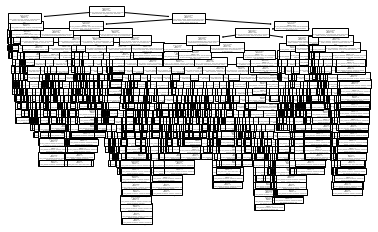

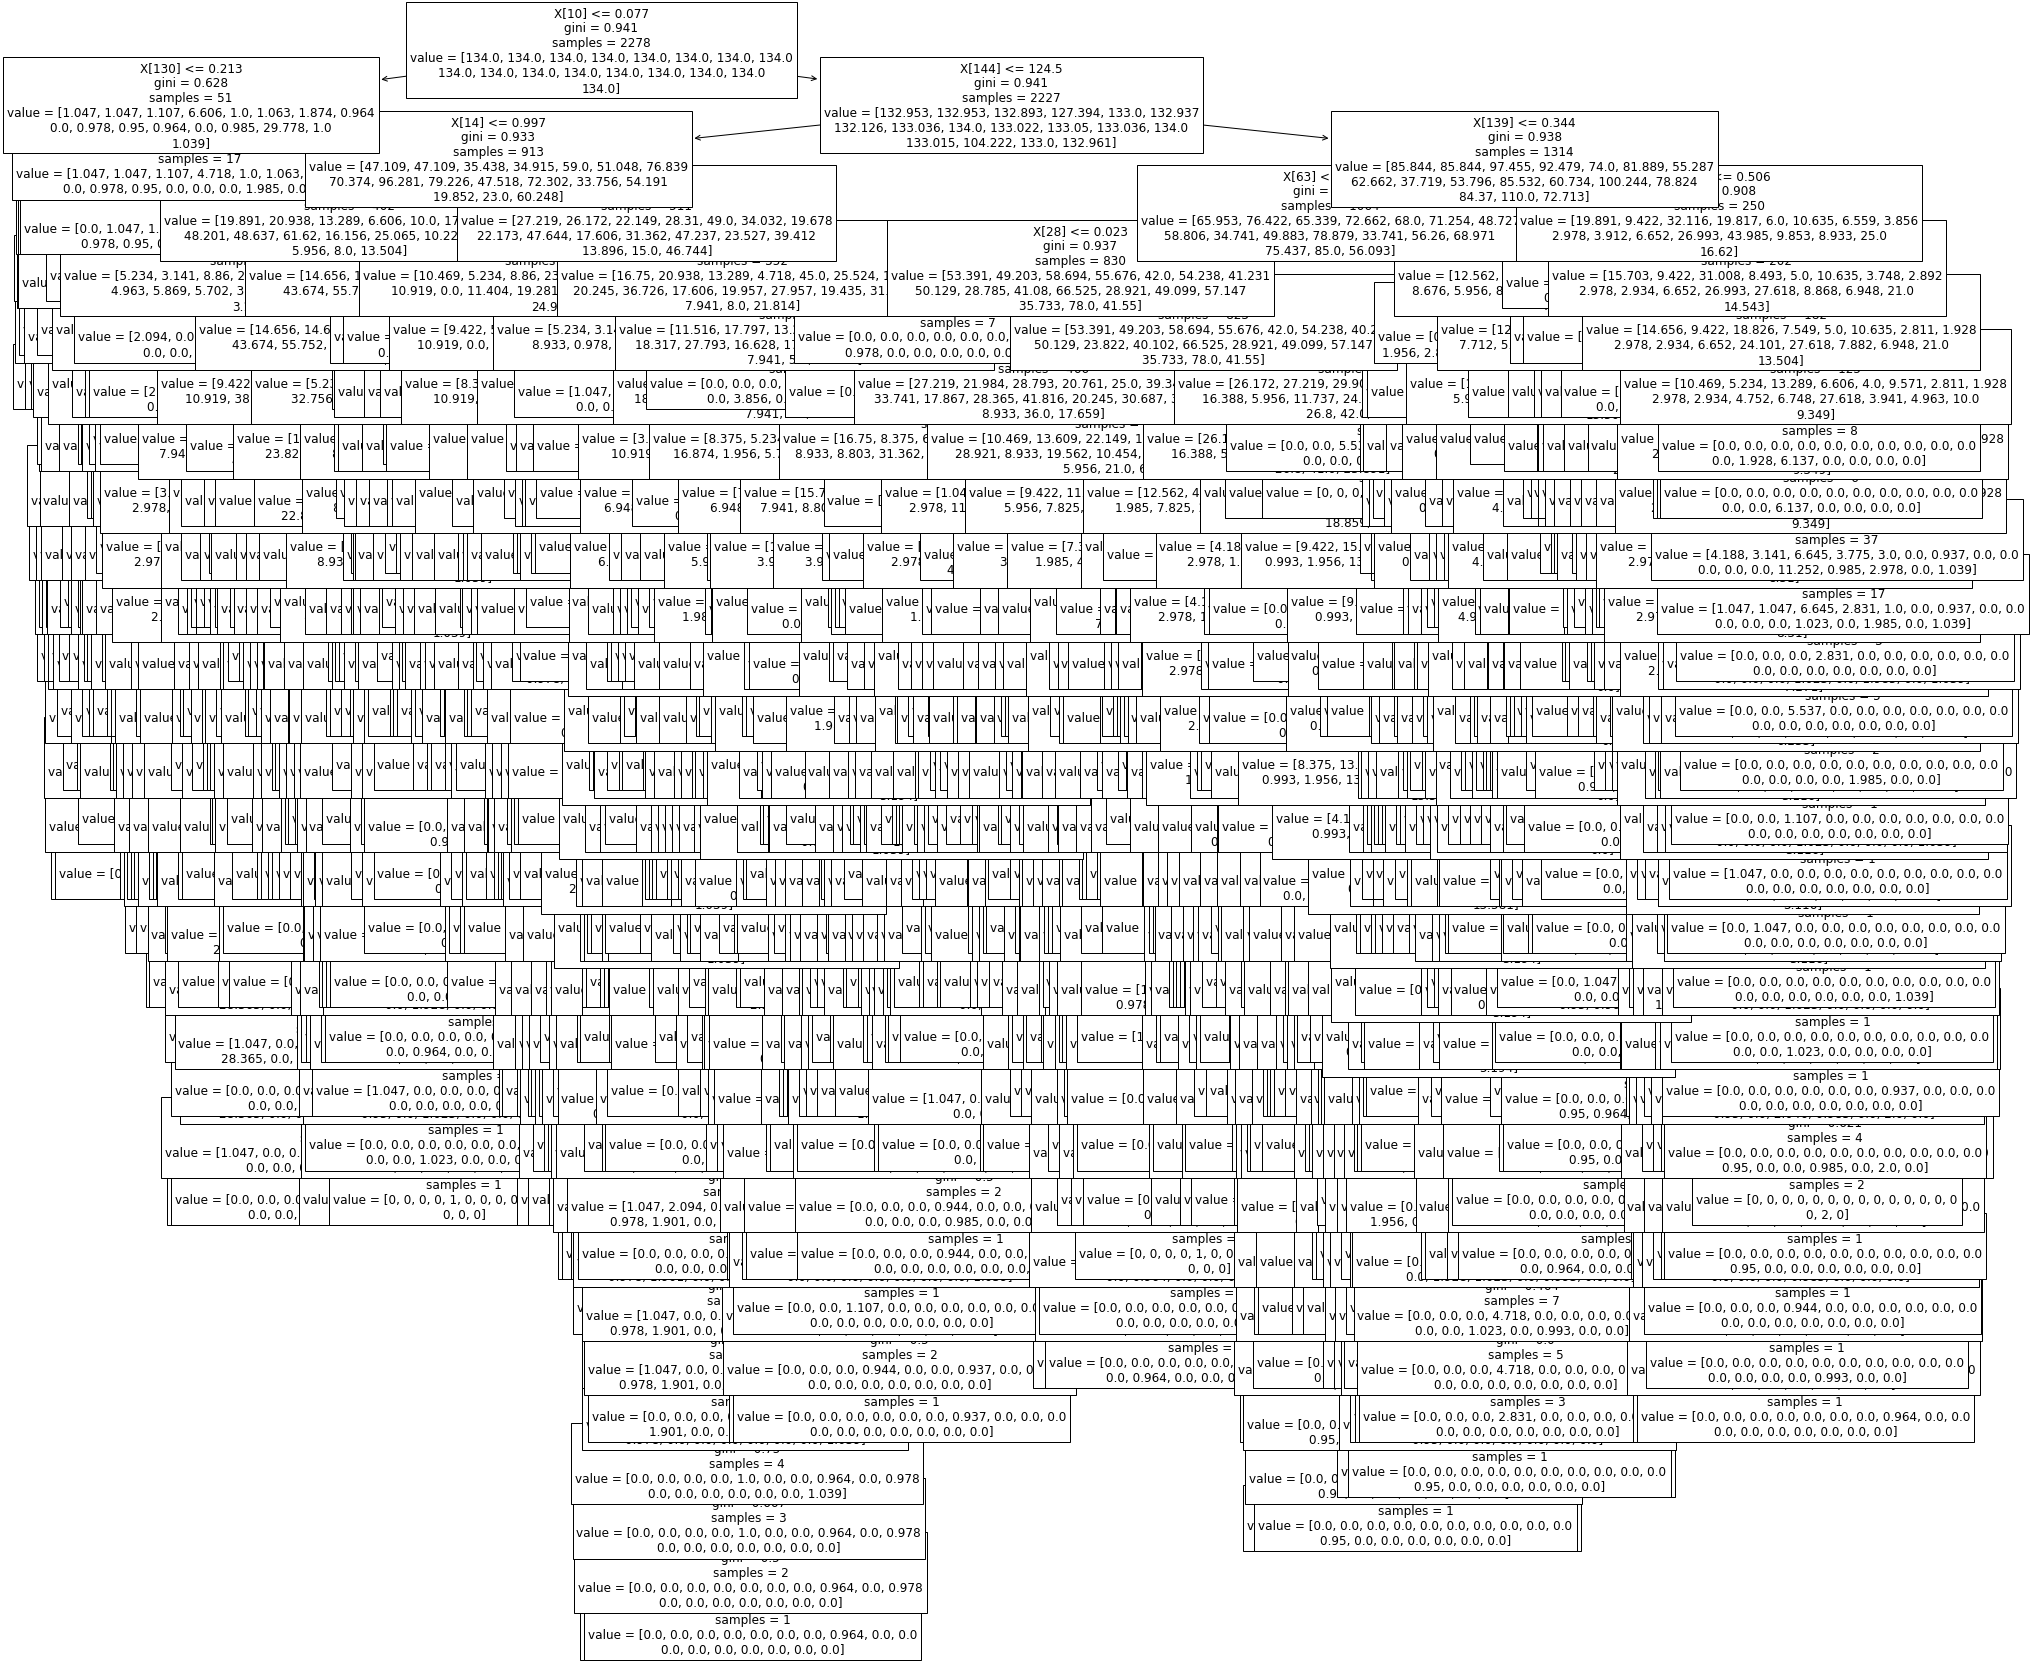

random forest:
accuracy_score:  0.3074866310160428
balanced accuracy score 0.26884833613015713


<Figure size 432x288 with 0 Axes>

In [4]:
#balanced mx size 150:
features = []
labels = []

for key in data.keys():

    if len(data[key]) > n:
        idx = np.random.randint(len(data[key]) -1, size=n)
        features_downsampled =data[key][idx,:]  

        features +=list(features_downsampled)
        labels += [key for i in range(len(features_downsampled))]
    else:
        features +=list(data[key])
        labels += [key for i in range(len(data[key]))]

        

features = np.array(features)

labels, translator =scale_y(labels)
labels = np.array(labels)
print(features.shape, labels.shape)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)
l, l_num = np.unique(y_train, return_counts=True)
print("labels train set", dict(zip(l, l_num)))
l, l_num = np.unique(y_test, return_counts=True)
print("labels test set", dict(zip(l, l_num)))

train(X_train, X_test, y_train, y_test)




In [3]:
all_features, labels_unedited =get_data()
all_features= np.array(all_features)
l, l_num = np.unique(labels_unedited, return_counts=True)
count_dict = dict(zip(l, l_num))
print(count_dict)

{1: 17, 2: 7526, 3: 996, 4: 224, 6: 2, 7: 174, 8: 74, 9: 1, 10: 775, 11: 4, 15: 1, 16: 1193, 17: 31, 18: 178, 19: 13, 21: 10, 23: 1, 24: 17, 25: 7, 26: 13, 31: 20, 32: 1211, 33: 150, 35: 1, 36: 1, 37: 52, 38: 3, 39: 1, 40: 6, 41: 3, 42: 7, 45: 3, 46: 7, 47: 39, 48: 139, 49: 6, 50: 2, 51: 38, 52: 1, 54: 1, 55: 1, 57: 5, 58: 2, 62: 1, 63: 381, 64: 74, 65: 1, 69: 848, 70: 380, 71: 652, 72: 122, 73: 49, 75: 2, 77: 5, 79: 1, 80: 125, 81: 1690, 82: 82, 83: 21, 85: 8, 86: 469, 87: 1, 88: 1, 89: 1963, 90: 1418, 92: 10, 94: 169, 95: 42, 99: 79, 100: 24, 102: 267, 103: 172, 105: 1, 106: 1, 108: 6, 109: 1, 111: 1, 113: 6, 115: 3091, 116: 8613}


In [17]:
all_features, labels_unedited =get_data()
#labels_unedited = np.array(list(map(get_family, labels_unedited)))
all_features= np.array(all_features)
l, l_num = np.unique(labels_unedited, return_counts=True)
count_dict = dict(zip(l, l_num))
print(count_dict)

used_keys_fam = [1, 2, 6, 13, 46, 47]
used_keys_fam = [1, 13]
used_keys_gatt = [2, 16, 32, 81, 115,116]
familys = {}
for key in used_keys_gatt:
    familys[key] = count_dict[key]
print(familys)
n = 223

{1: 17, 2: 7526, 3: 996, 4: 224, 6: 2, 7: 174, 8: 74, 9: 1, 10: 775, 11: 4, 15: 1, 16: 1193, 17: 31, 18: 178, 19: 13, 21: 10, 23: 1, 24: 17, 25: 7, 26: 13, 31: 20, 32: 1211, 33: 150, 35: 1, 36: 1, 37: 52, 38: 3, 39: 1, 40: 6, 41: 3, 42: 7, 45: 3, 46: 7, 47: 39, 48: 139, 49: 6, 50: 2, 51: 38, 52: 1, 54: 1, 55: 1, 57: 5, 58: 2, 62: 1, 63: 381, 64: 74, 65: 1, 69: 848, 70: 380, 71: 652, 72: 122, 73: 49, 75: 2, 77: 5, 79: 1, 80: 125, 81: 1690, 82: 82, 83: 21, 85: 8, 86: 469, 87: 1, 88: 1, 89: 1963, 90: 1418, 92: 10, 94: 169, 95: 42, 99: 79, 100: 24, 102: 267, 103: 172, 105: 1, 106: 1, 108: 6, 109: 1, 111: 1, 113: 6, 115: 3091, 116: 8613}
{2: 7526, 16: 1193, 32: 1211, 81: 1690, 115: 3091, 116: 8613}


In [18]:
n = 1200

used_labels = used_keys_gatt
#for key in count_dict.keys():
#    if count_dict[key] >= n:
#        used_labels.append(key)
print(used_labels)
data = {}
for l in used_labels:
    data[l] = all_features[labels_unedited == l]
for key in data.keys():
    print(key," ", len(data[key]))




features = []
labels = []

for key in data.keys():

    if len(data[key]) > n:
        idx = np.random.randint(len(data[key]) -1, size=n)
        features_downsampled =data[key][idx,:]  

        features +=list(features_downsampled)
        labels += [key for i in range(len(features_downsampled))]
    else:
        features +=list(data[key])
        labels += [key for i in range(len(data[key]))]

        

features = np.array(features)

labels, translator =scale_y(labels)
labels = np.array(labels)
print(features.shape, labels.shape)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)
l, l_num = np.unique(y_train, return_counts=True)
print("labels train set", dict(zip(l, l_num)))
l, l_num = np.unique(y_test, return_counts=True)
print("labels test set", dict(zip(l, l_num)))

train(X_train, X_test, y_train, y_test)

[2, 16, 32, 81, 115, 116]
2   7526
16   1193
32   1211
81   1690
115   3091
116   8613
(7193, 160) (7193,)
labels train set {0: 786, 1: 799, 2: 803, 3: 812, 4: 804, 5: 815}
labels test set {0: 414, 1: 394, 2: 397, 3: 388, 4: 396, 5: 385}
decission Tree
accuracy_score:  0.38500421229991577
balanced accuracy score 0.2620273407732192
decission tree depth= 20
accuracy_score:  0.3887952822240944
balanced accuracy score 0.2665666569114677
random forest:
accuracy_score:  0.4953664700926706
balanced accuracy score 0.39492094090726015
